In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 8
EPOCHS = 10
DATASET_DIR = './data/'
MODELS_DIR = 'models/'
print(torch.cuda.get_device_name())

Using cuda device
NVIDIA GeForce RTX 3060


In [3]:
from torchvision.io import read_image

sizes = []
for image in os.listdir('./data/images/colored_labels'):
    sizes.append(read_image("./data/images/colored_labels/" + image).shape)
print("Range for inputs with segmentation: ")
print(max(sizes))
print(min(sizes))

sizes = []
for image in os.listdir('./data/images/text_labels'):
    sizes.append(read_image("./data/images/text_labels/" + image).shape)
print("Range for inputs with txt: ")
print(max(sizes))
print(min(sizes))


Range for inputs with segmentation: 
torch.Size([3, 873, 550])
torch.Size([3, 801, 550])
Range for inputs with txt: 
torch.Size([3, 877, 550])
torch.Size([3, 786, 550])


No necesito que me prediga el color exacto de cada categoría, si sabe que es un vestido, luego busco en la tabla su color y listo. 

Para ello, en la siguiente celda creo un codificador y decodificador de one hot a una de las clases, cada una asociada a un color:

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import joblib

classes = pd.read_csv(DATASET_DIR + "/class_dict.csv")

# Si tuvieramos que volver a crear el codificar las líneas serían las siguientes:
#encoder = OneHotEncoder(sparse=False) #joblib.dump(encoder,"one_hot_encoder.joblib")
#codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1))
encoder = joblib.load('one_hot_encoder.joblib')
codes = encoder.transform(classes["class_name"].values.reshape(-1,1))
codigo_none = codes[0]
codigo_accesorios = codes[1]

uncoded = encoder.inverse_transform([codigo_none, codigo_accesorios])
print("one hot de nada y de accesorios devuelve segun encoder: ", uncoded)

print("Sus colores segun el dataframe: \n", classes[classes["class_name"].isin(uncoded.flatten())][["r","g","b"]])

one hot de nada y de accesorios devuelve segun encoder:  [['none']
 ['accessories']]
Sus colores segun el dataframe: 
     r   g   b
0  69   6  90
1  70  12  95


Dataset para cargar imágenes:

In [5]:
import numpy as np

encoder = OneHotEncoder(sparse=False)
codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1)).astype(np.uint8)

encoded_df = pd.concat([classes, pd.Series(list(codes[:]))], axis=1).rename(columns={0: "One-hot"}, inplace=False)
encoded_df["array_value"] = encoded_df[["r","g","b"]].apply(lambda x: np.array([x.r, x.g, x.b], dtype=np.uint8), axis=1)
encoded_df["tensor_value"] = encoded_df[["r","g","b"]].apply(lambda x: torch.tensor([x.r, x.g, x.b], dtype=torch.uint8), axis=1)
encoded_df

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,class_name,r,g,b,One-hot,array_value,tensor_value
0,none,69,6,90,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[69, 6, 90]","[tensor(69, dtype=torch.uint8), tensor(6, dtyp..."
1,accessories,70,12,95,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 12, 95]","[tensor(70, dtype=torch.uint8), tensor(12, dty..."
2,bag,71,18,101,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 18, 101]","[tensor(71, dtype=torch.uint8), tensor(18, dty..."
3,belt,72,25,107,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 25, 107]","[tensor(72, dtype=torch.uint8), tensor(25, dty..."
4,blazer,72,30,112,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 30, 112]","[tensor(72, dtype=torch.uint8), tensor(30, dty..."
5,blouse,72,35,116,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 35, 116]","[tensor(72, dtype=torch.uint8), tensor(35, dty..."
6,bodysuit,71,40,120,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 40, 120]","[tensor(71, dtype=torch.uint8), tensor(40, dty..."
7,boots,70,47,124,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 47, 124]","[tensor(70, dtype=torch.uint8), tensor(47, dty..."
8,bra,69,52,127,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[69, 52, 127]","[tensor(69, dtype=torch.uint8), tensor(52, dty..."
9,bracelet,68,57,130,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[68, 57, 130]","[tensor(68, dtype=torch.uint8), tensor(57, dty..."


In [6]:
encoded_df["byte_value"] = encoded_df["array_value"].apply(lambda x: x.tobytes())

array_to_onehot = encoded_df[["byte_value", "One-hot"]].set_index('byte_value').to_dict()["One-hot"]
array_to_onehot

{b'E\x06Z': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'F\x0c_': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'G\x12e': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'H\x19k': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'H\x1ep': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

In [7]:
from CustomClothingDataset import CustomClothingDataset 


Para preprocesar todas las imágenes de segmentación (labels), y evitar que tengamos que codificarlas en one hot en cada ejecución, las preprocesamos antes:

In [8]:
#LabelEncoder("./data/labels/pixel_level_labels_colored", "./data/labels/processed_pixel_labels/",
#                  "./data/class_dict.csv", "./one_hot_encoder.joblib").preprocess()
# Ejecutar únicamente si no se ejecuto antes
# Antes de ejecutar, crear carpeta en /data/labels/processed_pixel_labels

Revertimos la codificacion para afianzar que es correcta:

In [9]:
dataset = CustomClothingDataset(root_dir=DATASET_DIR) 
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE) 

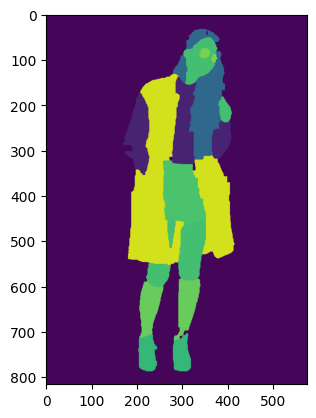

In [10]:

import matplotlib.pyplot as plt

onehot_to_array = {v.tobytes(): k for k, v in array_to_onehot.items()}
def decode_image(image):
    return np.apply_along_axis(lambda pixel: np.frombuffer(onehot_to_array[pixel.tobytes()], dtype=np.uint8), 0, np.array(image, np.uint8)).transpose(1,2,0)
    


label = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[1]
plt.imshow(decode_image(label))

Cantidad de imágenes:  1004


C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([59, 496, 304])


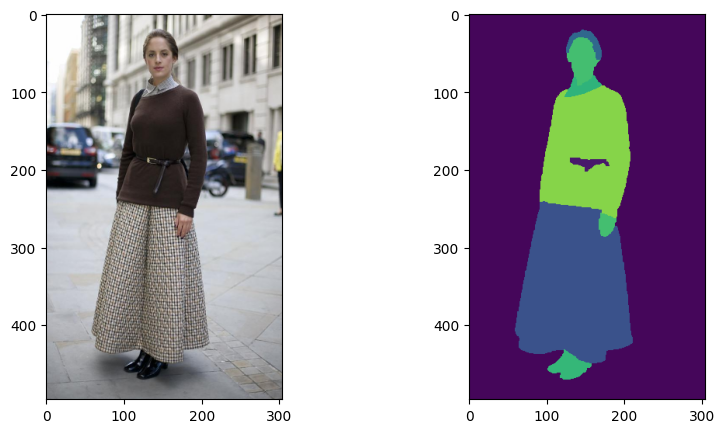

In [11]:
from torchvision.transforms import InterpolationMode
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

dataset = CustomClothingDataset(root_dir=DATASET_DIR,
                                transform_input=transforms.Compose([
                     transforms.Resize((496, 304)), 
                 ]),
                                transform_labels=transforms.Compose([transforms.Resize((496, 304), interpolation=InterpolationMode.NEAREST_EXACT)                                                                  
    ])
                                )
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Cantidad de imágenes: ", len(data_loader.dataset))

for image, label in data_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(image[0].int(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    print(label[0].shape)
    plt.imshow(decode_image(label[0]))
    plt.show()
    break

## Implementación 1
### Modelo U-NET

Creación del modelo:

Hay que coger imagenes con el mismo grosor y altura para meterlos como input en la u-net, no vale `877x550` sino al mejor `560x560` para evitar coger el mayor porque puede generar ruido en la imagen, y tambien porque ese valor es divisible por 2 para pooling y unpooling, se prefiere compactarlo que generar ruido.

In [12]:
from models.Unet import Unet

#inputs = torch.randn((2, 3, 560, 560)).to(device)
inputs = torch.randn((4, 3, 512, 512))#.to(device)
model = Unet()#.to(device)
y = model(inputs)
print(y.shape)

torch.Size([4, 59, 512, 512])


In [22]:
from torch.utils.data import random_split

BATCH_SIZE = 16
full_dataset = CustomClothingDataset(root_dir=DATASET_DIR,                 
                                     transform_input=transforms.Compose([
                     transforms.Resize((496, 304), interpolation=InterpolationMode.BILINEAR, antialias=True), 
                     transforms.Lambda(lambda x: x / 255),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                 ]),
                                     
                                     transform_labels=transforms.Compose([
                    transforms.Resize((496, 304), interpolation=InterpolationMode.NEAREST_EXACT),
                 ]),)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
 
loss_fn = torch.nn.CrossEntropyLoss()


### Implementación U-NET

In [14]:
from trainers.ModelTrainer import ModelTrainer
from trainers.TransferLearningTrainer import TransferLearningTrainer 
from EarlyStopper import EarlyStopper
from torch.optim.lr_scheduler import ReduceLROnPlateau

Epoch: 1, Train acc: 72.47802766259632, loss: 1.40849115496332 //// Val acc: 76.3446519524618 loss: 1.4606694340705872
Epoch: 2, Train acc: 78.06646359510057, loss: 0.9242377077991312 //// Val acc: 77.35677083333333 loss: 0.9241387605667114
Epoch: 3, Train acc: 79.1330966369432, loss: 0.8558025820688768 //// Val acc: 78.83210420203734 loss: 0.8550073087215424
Epoch: 4, Train acc: 79.40981934044856, loss: 0.8217737471515482 //// Val acc: 79.33857261601584 loss: 0.8512271702289581
Epoch: 5, Train acc: 79.93192900378014, loss: 0.7834762239998038 //// Val acc: 78.76399794850028 loss: 0.8514919936656952
Epoch: 6, Train acc: 80.05717089240538, loss: 0.7634844468398527 //// Val acc: 79.54525679117147 loss: 0.7885053098201752
Epoch: 7, Train acc: 80.51921085432599, loss: 0.7396328002214432 //// Val acc: 80.61458333333334 loss: 0.7951396942138672
Epoch: 8, Train acc: 80.91781598718673, loss: 0.7169375717639923 //// Val acc: 80.8973940647991 loss: 0.7075792670249939
Epoch: 9, Train acc: 81.58100

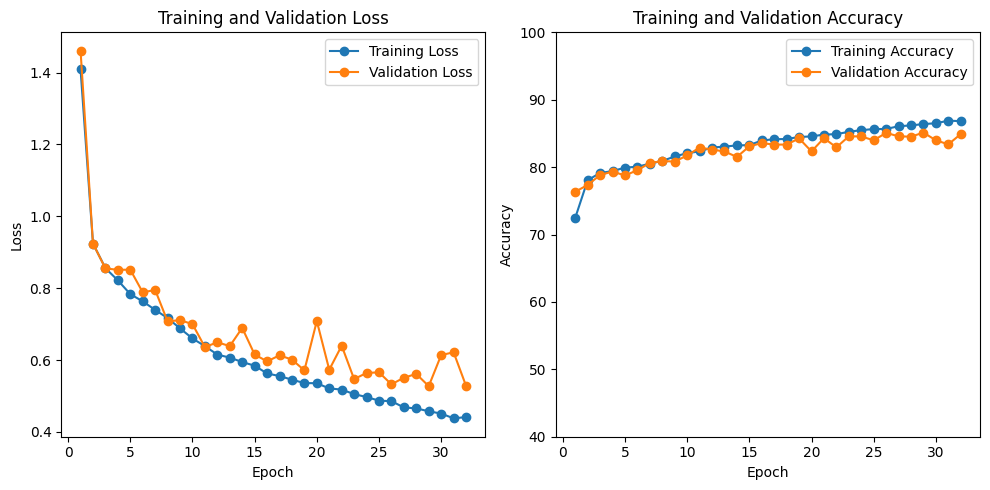

Test Accuracy: 84.5%, Avg loss: 0.541486 


In [15]:
model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)
unetTrainer = ModelTrainer(model, optimizer, loss_fn, 32, EarlyStopper(patience=7), device, scheduler)
unetTrainer.train_and_val(train_loader, val_loader)
unetTrainer.draw_results()
unetTrainer.test(test_loader)


In [18]:

#unetTrainer.result.to_csv(r".\results\unet.csv",index=False)

In [19]:
#torch.save(unetTrainer.model, r".\results\unet.pth")

## Otras implementaciones

Para más implementaciones, se consideran dos modelos que son distintos uno al otro, dado que uno es considerado un modelo grande y otro, pequeño.
Ambos utilizan la versión de **DeepLabV3**, preentrenado en ImageNet como _"espinazo"_ (backbone), esto significa que ha aprendido representaciones útiles de una amplia variedad de imágenes. 
- La **ResNet50** es conocida por su profundidad y capacidad para capturar características complejas. Al tener 50 capas, puede aprender representaciones jerárquicas profundas que podrían ser beneficiosas para tareas de segmentación más complejas. Ayuda a mitigar el problema de desvanecimiento del gradiente, lo que facilita el entrenamiento de modelos más profundos.
- La **MobileNetV3**, es conocida por su eficiencia computacional y su capacidad para ejecutarse en dispositivos con recursos limitados. En este caso ya que tenemos a nuestra disposición una GPU y poseemos los recursos, se usa la versión _large_. Aunque, tiene menos parámetros en comparación con modelos más grandes (ResNet50), lo que puede ser beneficioso para tareas donde el conjunto de datos no es extremadamente grande.

#### Consideraciones Adicionales
Ambos modelos se benefician de la transferencia de aprendizaje al ser preentrenados en conjuntos de datos grandes como ImageNet. Esto puede ser beneficioso cuando se tiene un conjunto de datos más pequeño, ya que el modelo ya ha aprendido características útiles.

In [15]:
from models.Resnet101 import Resnet101
from models.MobileNetV3 import MobileNetV3
from models.ResNet50 import ResNet50

#### ResNet50

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train acc: 1.786962138856239, loss: 4.005847492001274 //// Val acc: 6.608389042161857 loss: 3.95332612991333
Epoch: 2, Train acc: 6.608862238438319, loss: 3.9043095870451494 //// Val acc: 21.947987408036223 loss: 3.842438220977783
Epoch: 3, Train acc: 17.511271193691076, loss: 3.799297582019459 //// Val acc: 37.66446042020374 loss: 3.7434356451034545
Epoch: 4, Train acc: 31.44434793084518, loss: 3.692364611408927 //// Val acc: 50.03623726655348 loss: 3.630712890625
Epoch: 5, Train acc: 43.98905915943533, loss: 3.583961405537345 //// Val acc: 57.47755730050934 loss: 3.51680645942688
Epoch: 6, Train acc: 52.71639301244565, loss: 3.4787895625287835 //// Val acc: 61.05144223967175 loss: 3.42935996055603
Epoch: 7, Train acc: 58.5339145915865, loss: 3.37891286611557 //// Val acc: 63.93654057017543 loss: 3.3223068952560424
Epoch: 8, Train acc: 62.28300217151818, loss: 3.2873077338392083 //// Val acc: 65.53281515280136 loss: 3.241568088531494
Epoch: 9, Train acc: 64.67637316102672, l

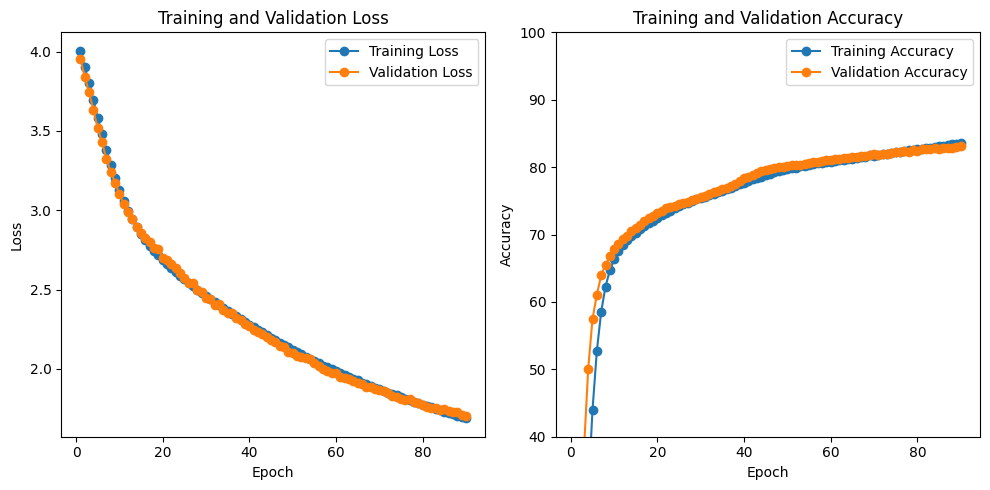

Test Accuracy: 83.8%, Avg loss: 1.676411 


In [16]:
resnet50_model = ResNet50(num_classes=59) #incluyendo el NONE
resnet50_model = resnet50_model.to(device)
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.000001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
resnet50_trainer = TransferLearningTrainer(resnet50_model, optimizer, loss_fn, 90, EarlyStopper(patience=3, min_delta=0.01, max_loss_diff=0.15), device, scheduler)
resnet50_trainer.train_and_val(train_loader, val_loader)
resnet50_trainer.draw_results()
resnet50_trainer.test(test_loader)

#### MobileNetV3

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train acc: 20.25356114019367, loss: 3.835468725724654 //// Val acc: 54.68573146576119 loss: 3.1878753900527954
Epoch: 2, Train acc: 54.949515149536374, loss: 3.2500561367381704 //// Val acc: 63.59450162705149 loss: 2.8696852684020997
Epoch: 3, Train acc: 66.70173598262785, loss: 2.8982701409946787 //// Val acc: 67.2134841893039 loss: 2.784334635734558
Epoch: 4, Train acc: 70.282561511737, loss: 2.7209601998329163 //// Val acc: 69.3087639714205 loss: 2.695072817802429
Epoch: 5, Train acc: 71.71538978494625, loss: 2.592383151704615 //// Val acc: 70.70789562110923 loss: 2.5740201473236084
Epoch: 6, Train acc: 72.42042181657791, loss: 2.4789256128397854 //// Val acc: 71.63051782682513 loss: 2.484891104698181
Epoch: 7, Train acc: 73.00336263356215, loss: 2.373446377840909 //// Val acc: 72.6423051075269 loss: 2.372963881492615
Epoch: 8, Train acc: 73.56323881651502, loss: 2.27590519731695 //// Val acc: 73.3436217812677 loss: 2.2965424776077272
Epoch: 9, Train acc: 74.02723720336994

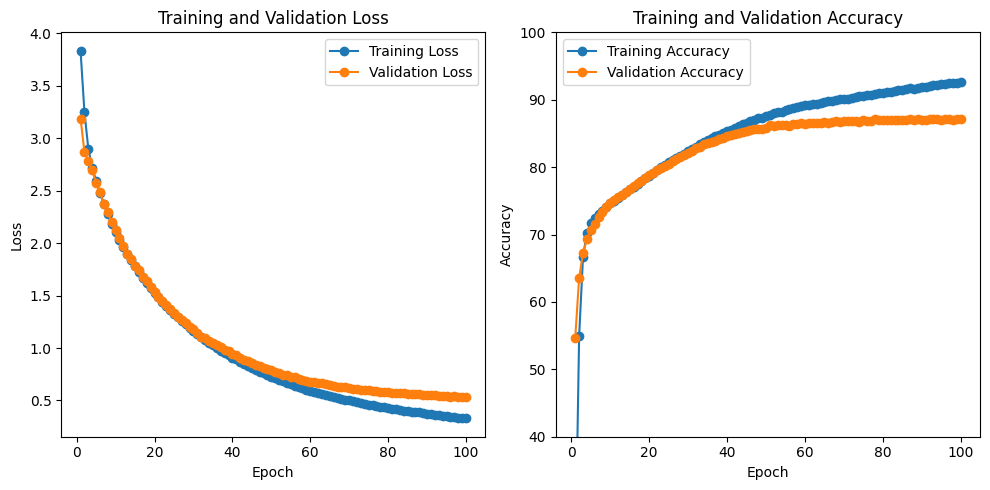

Test Accuracy: 87.4%, Avg loss: 0.497752 


In [17]:
mobilenetv3_model = MobileNetV3(num_classes=59)
mobilenetv3_model = mobilenetv3_model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenetv3_model.parameters(), lr=0.00001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
mobilenetv3_trainer = TransferLearningTrainer(mobilenetv3_model, optimizer, loss_fn, 100, EarlyStopper(patience=3, min_delta=0.01), device, scheduler)
mobilenetv3_trainer.train_and_val(train_loader, val_loader)
mobilenetv3_trainer.draw_results()
mobilenetv3_trainer.test(test_loader)

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train acc: 16.750620082870185, loss: 4.00531096350063 //// Val acc: 52.575794956140356 loss: 3.484263849258423
Epoch: 2, Train acc: 55.99196972087994, loss: 3.364262282848358 //// Val acc: 62.83290446378042 loss: 3.071367025375366
Epoch: 3, Train acc: 66.91364644098357, loss: 2.996344409205697 //// Val acc: 67.75772407328806 loss: 2.8675694465637207
Epoch: 4, Train acc: 70.46581359074727, loss: 2.8076877919110386 //// Val acc: 69.63787935059423 loss: 2.745561146736145
Epoch: 5, Train acc: 71.76815294586409, loss: 2.667502511631359 //// Val acc: 71.14173033389926 loss: 2.6175883054733275
Epoch: 6, Train acc: 72.5018121807569, loss: 2.5445354797623376 //// Val acc: 72.13346685766837 loss: 2.506333422660828
Epoch: 7, Train acc: 73.04463126665748, loss: 2.4305905537171797 //// Val acc: 72.58223684210526 loss: 2.4193275451660154
Epoch: 8, Train acc: 73.44760388551505, loss: 2.3297712965445085 //// Val acc: 73.18866281126202 loss: 2.315626859664917
Epoch: 9, Train acc: 73.789209688

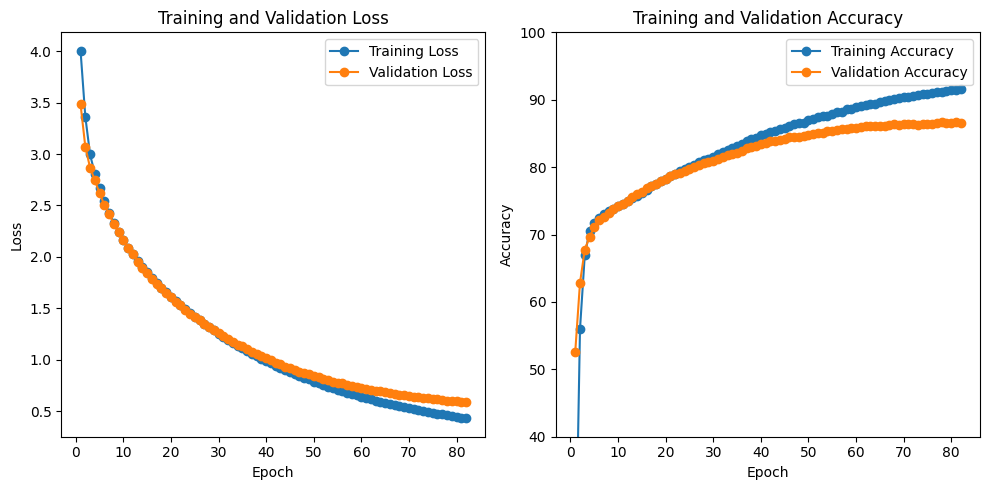

Test Accuracy: 86.3%, Avg loss: 0.616648 


In [23]:
mobilenetv3_model = MobileNetV3(num_classes=59)
mobilenetv3_model = mobilenetv3_model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenetv3_model.parameters(), lr=0.00001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
mobilenetv3_trainer = TransferLearningTrainer(mobilenetv3_model, optimizer, loss_fn, 85, EarlyStopper(patience=3, min_delta=0.01, max_loss_diff=0.15), device, scheduler)
mobilenetv3_trainer.train_and_val(train_loader, val_loader)
mobilenetv3_trainer.draw_results()
mobilenetv3_trainer.test(test_loader)

#### FCN_RESNET_101

In [16]:
BATCH_SIZE=12
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train acc: 31.24053853076826, loss: 3.622124336533627 //// Val acc: 60.56906568336162 loss: 3.1048515209784875
Epoch: 2, Train acc: 64.2574440553669, loss: 2.8471940695229225 //// Val acc: 70.21459394453876 loss: 2.5866464651547947
Epoch: 3, Train acc: 72.02958141817703, loss: 2.4137350866350076 //// Val acc: 74.68001025749858 loss: 2.261258363723755
Epoch: 4, Train acc: 75.51528682451062, loss: 2.1651118933144264 //// Val acc: 76.8856731041313 loss: 2.1067290122692404
Epoch: 5, Train acc: 77.74026633521012, loss: 2.0055746931140708 //// Val acc: 79.09519135540464 loss: 1.9199679081256573
Epoch: 6, Train acc: 79.2958017869149, loss: 1.884709241026539 //// Val acc: 80.00456723967174 loss: 1.8371480978452241
Epoch: 7, Train acc: 80.37125104751642, loss: 1.7919235189082259 //// Val acc: 81.15897354272778 loss: 1.7388490163362944
Epoch: 8, Train acc: 81.24555788034668, loss: 1.7222945265850778 //// Val acc: 81.88353759903792 loss: 1.6849870773462148
Epoch: 9, Train acc: 81.810689

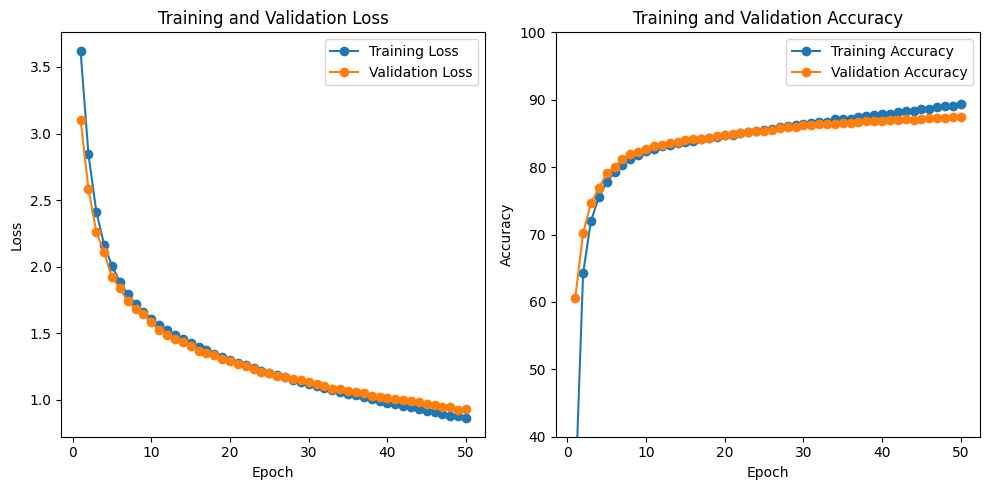

Test Accuracy: 87.3%, Avg loss: 0.916432 


In [17]:
fcn_resnet_101_model = Resnet101(num_classes=59)
fcn_resnet_101_model = fcn_resnet_101_model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcn_resnet_101_model.parameters(), lr=0.000001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
fcn_resnet_101_model_trainer = TransferLearningTrainer(fcn_resnet_101_model, optimizer, loss_fn, 50, EarlyStopper(patience=3, min_delta=0.01, max_loss_diff=0.15), device, scheduler)
fcn_resnet_101_model_trainer.train_and_val(train_loader, val_loader)
fcn_resnet_101_model_trainer.draw_results()
fcn_resnet_101_model_trainer.test(test_loader)

In [20]:
fcn_resnet_101_model_trainer.result.to_csv(r".\results\\Resnet101.csv" ,index=False)

In [24]:
trainers = {"MobileNetV3": mobilenetv3_trainer, "ResNet50":resnet50_trainer, 
            "Resnet101":fcn_resnet_101_model_trainer}
for k,v in trainers.items():
    #v.result.to_csv(r".\results\\" + k + ".csv" ,index=False)
    #torch.save(v.model.state_dict(), r".\results\\" + k + ".pth")
    pass

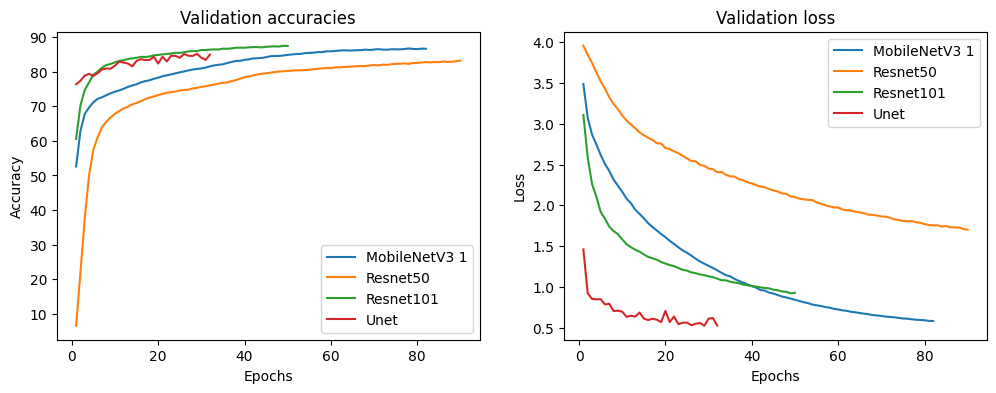

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Lista de nombres de archivos CSV y modelos
csv_files = ['MobileNetV3.csv', 'Resnet50.csv', 'Resnet101.csv', 'Unet.csv']
model_names = ['MobileNetV3 1', 'Resnet50', 'Resnet101', 'Unet']

# Inicializar listas para almacenar datos
val_loss_data = []
val_acc_data = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Leer datos de los archivos CSV y almacenar en las listas
for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(r".\results\\" + csv_file)
    ax1.plot(df["Epoch"], df["val_acc"], label=model_names[i])
    ax2.plot(df["Epoch"], df["val_loss"], label=model_names[i])



# Plot the data


# Set labels and title
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Validation accuracies')

# Add a legend
ax1.legend()

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Validation loss')

# Add a legend
ax2.legend()

# Show the plot
plt.show()

Se discute la mejor entre MobileNetV3 con mejor pérdida, y Resnet101 con mejor accuracy.

Una matriz de confusión en este caso no es muy intuitiva, pues las matrices de confusión tratan de visualizar que clases predice con mejor acierto y con cuáles confunde las de peor acierto. Sin embargo, cuando tratamos con salidas como la siguiente por cada muestra:

real_classes = ['none', 'hair', 'skin', 'sunglasses', 'vest', 'blouse', 'skirt', 'stockings', 'shoes']
predicted_classes = ['none', 'hair', 'skin', 'blouse', 'blazer', 'suit', 'shorts', 'dress', 'jacket', 'coat', 'jeans', 'bag', 'skirt', 'shoes']

No podemos saber que confundió con una mochila de forma directa sin comprobaciones píxel por píxel.

Si podemos ver cuales suele acertar y cuales suele fallar:

In [46]:
from LabelManagement.LabelDecoder import LabelDecoder

model = fcn_resnet_101_model_trainer.model
model.eval()
count = 0
max_test = 10
decoder = LabelDecoder(class_dict_path="./data/class_dict.csv", encoder_path='one_hot_encoder.joblib')

def model_output(model, x, y):
    out = model(x.unsqueeze(0))["out"].argmax(1).squeeze(0)
    return torch.zeros_like(y).to(device).scatter_(0, out.unsqueeze(0), 1.)

predict_list = []
real_list = []
for x, y in test_loader:
    for input, label in zip(x.unbind(0), y.unbind(0)):       
        predict, classes_predicted = decoder.decode_labels(model_output(model, input.to(device), label.to(device)).cpu())
        img, classes_real = decoder.decode_labels(label)
        predict_list.append(classes_predicted)
        real_list.append(classes_real)  



In [160]:

dicc_good = {}
dicc_not_predicted = {}
dicc_bad_predicted = {}
def add_to_dic(dic, item):
    if item not in dic.keys():
        dic[item] = 1
    else:
        dic[item] += 1
               
for i in range(len(real_list)):
    predicted_copy = predict_list[i].copy()
    for j in range(len(real_list[i])):
        if real_list[i][j] in predict_list[i]:
            add_to_dic(dicc_good, real_list[i][j])
            predicted_copy.remove(real_list[i][j])
        else:
            add_to_dic(dicc_not_predicted, real_list[i][j])
    for class_not_predicted in predicted_copy:
        add_to_dic(dicc_bad_predicted, class_not_predicted)

In [162]:
from collections import OrderedDict

for classs in encoded_df.class_name:
    for dict in [dicc_good, dicc_bad_predicted, dicc_not_predicted]:
        if classs not in dict.keys():
            dict[classs] = 0
        dict = OrderedDict(sorted(dict.items()))
        
dicc_good = OrderedDict(sorted(dicc_good.items()))
dicc_bad_predicted = OrderedDict(sorted(dicc_bad_predicted.items()))
dicc_not_predicted = OrderedDict(sorted(dicc_not_predicted.items()))

In [164]:

import numpy as np

# Sample data
labels = encoded_df.class_name

all_values = list(dicc_good.values())
all_values.extend(list(dicc_bad_predicted.values()))
all_values.extend(list(dicc_not_predicted.values()))

max_value = max(all_values)
values1 = np.array(list(dicc_good.values())) / max_value
values2 = np.array(list(dicc_bad_predicted.values())) / max_value
values3 = np.array(list(dicc_not_predicted.values())) / max_value
results = pd.DataFrame({"Label":dicc_good.keys(), "Good predict":values1, "Bad predict":values2, "Not predicted":values3})
results.sort_values(by=['Good predict'], ascending=False)

,Label,Good predict,Bad predict,Not predicted
29,none,1.000000,0.000000,0.000000
41,skin,1.000000,0.000000,0.000000
18,hair,0.967105,0.032895,0.000000
39,shoes,0.750000,0.243421,0.006579
1,bag,0.335526,0.309211,0.078947
31,pants,0.296053,0.388158,0.000000
13,dress,0.250000,0.328947,0.019737
4,blouse,0.184211,0.401316,0.052632
12,coat,0.171053,0.585526,0.000000
24,jeans,0.151316,0.282895,0.026316


In [165]:
results.sort_values(by=['Bad predict'], ascending=False)

,Label,Good predict,Bad predict,Not predicted
12,coat,0.171053,0.585526,0.000000
4,blouse,0.184211,0.401316,0.052632
31,pants,0.296053,0.388158,0.000000
13,dress,0.250000,0.328947,0.019737
1,bag,0.335526,0.309211,0.078947
24,jeans,0.151316,0.282895,0.026316
38,shirt,0.111842,0.269737,0.032895
46,suit,0.072368,0.250000,0.000000
39,shoes,0.750000,0.243421,0.006579
23,jacket,0.072368,0.210526,0.006579


In [167]:
results.sort_values(by=['Not predicted'], ascending=False)

,Label,Good predict,Bad predict,Not predicted
47,sunglasses,0.000000,0.000000,0.361842
0,accessories,0.000000,0.000000,0.276316
33,purse,0.006579,0.032895,0.203947
2,belt,0.000000,0.000000,0.177632
6,boots,0.000000,0.000000,0.085526
44,socks,0.000000,0.000000,0.078947
1,bag,0.335526,0.309211,0.078947
19,hat,0.039474,0.000000,0.078947
3,blazer,0.013158,0.085526,0.072368
8,bracelet,0.000000,0.000000,0.072368


Real classes: ['none', 'hair', 'skin', 'dress', 'belt', 'bag', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'dress', 'shoes']


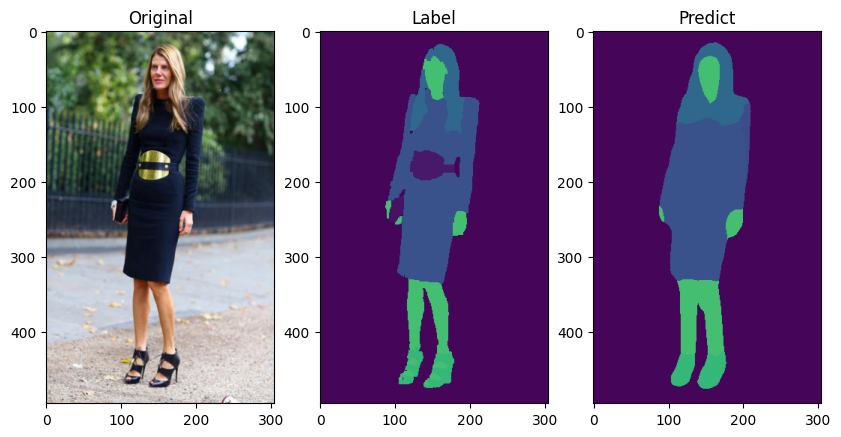

Real classes: ['none', 'hair', 'skin', 'blouse', 'vest', 'bag', 'belt', 'pants', 'accessories', 'sandals']
Predicted classes: ['none', 'hair', 'skin', 'blouse', 'coat', 'sweater', 'dress', 'bag', 'pants', 'shoes']


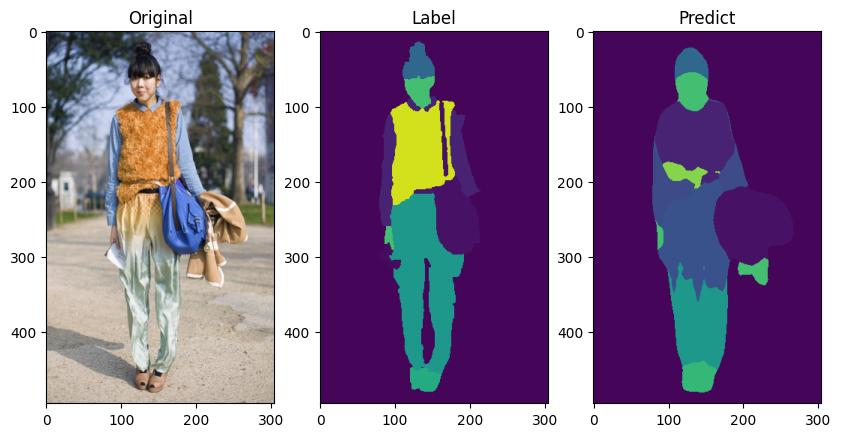

Real classes: ['none', 'hair', 'skin', 'cape', 'accessories', 'stockings', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'blouse', 'dress', 'cape', 'bag', 'pants', 'jeans', 'stockings', 'shoes']


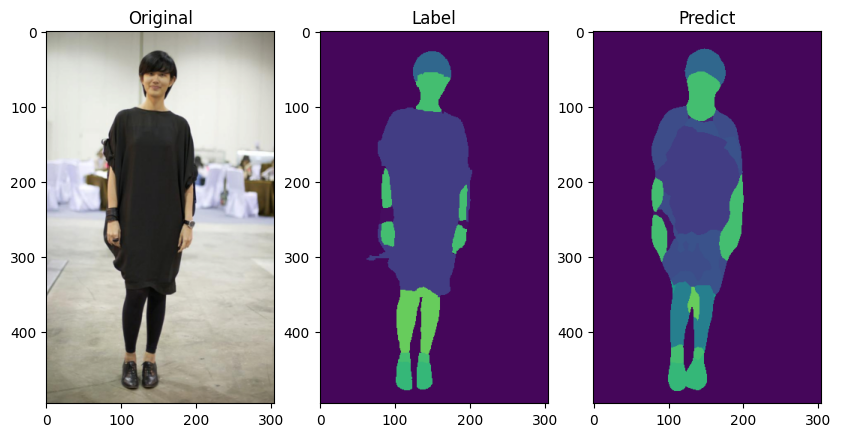

Real classes: ['none', 'hair', 'skin', 'coat', 'bag', 'jeans', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'jeans', 'bag', 'pants', 'shoes']


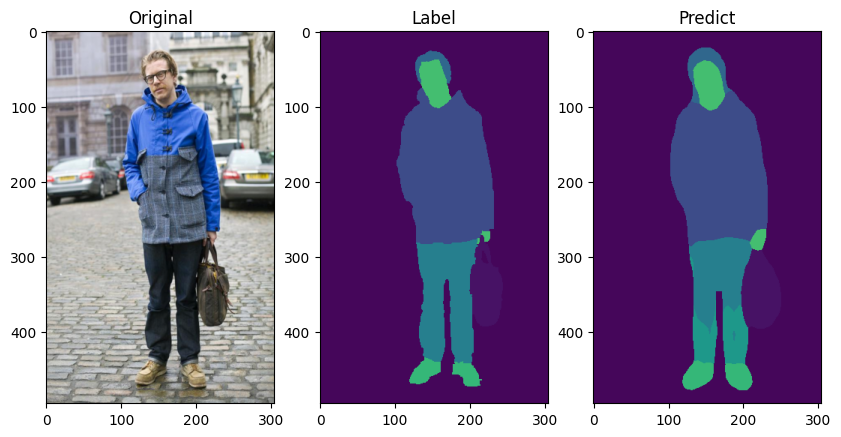

Real classes: ['none', 'hair', 'skin', 'blouse', 'coat', 'bag', 'jeans', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'bag', 'jeans', 'pants', 'shoes']


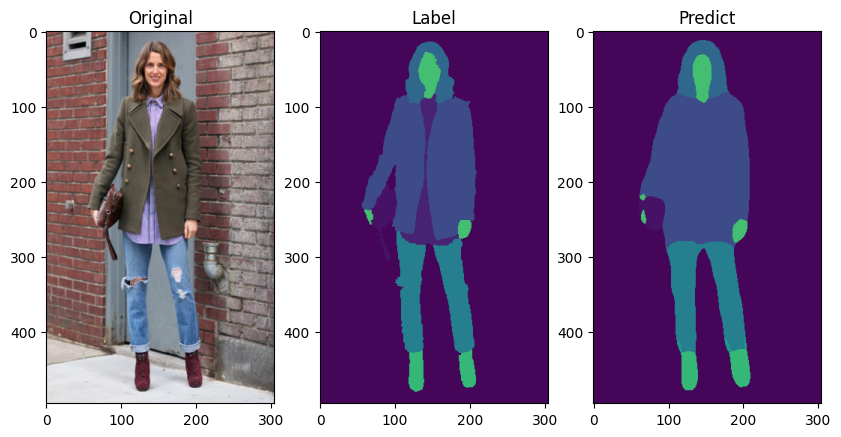

Real classes: ['none', 'hair', 'skin', 'sunglasses', 'necklace', 'dress', 'accessories', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'dress', 'shoes']


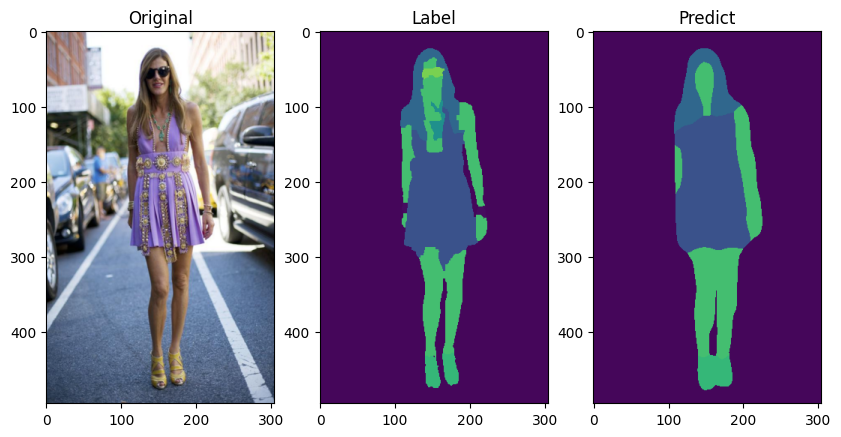

Real classes: ['none', 'hair', 'skin', 'sunglasses', 'sweater', 'bag', 'skirt', 'stockings', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'blouse', 'sweater', 'jacket', 'bag', 'jeans', 'skirt', 'dress', 'pants', 'shoes']


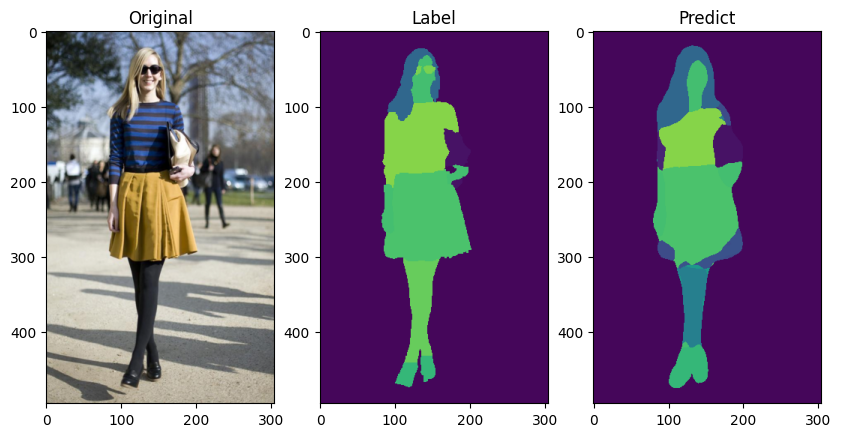

Real classes: ['none', 'hair', 'skin', 'blouse', 'bag', 'dress', 'purse', 'boots']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'jacket', 'shirt', 'blouse', 'dress', 'pants', 'bag', 'shoes']


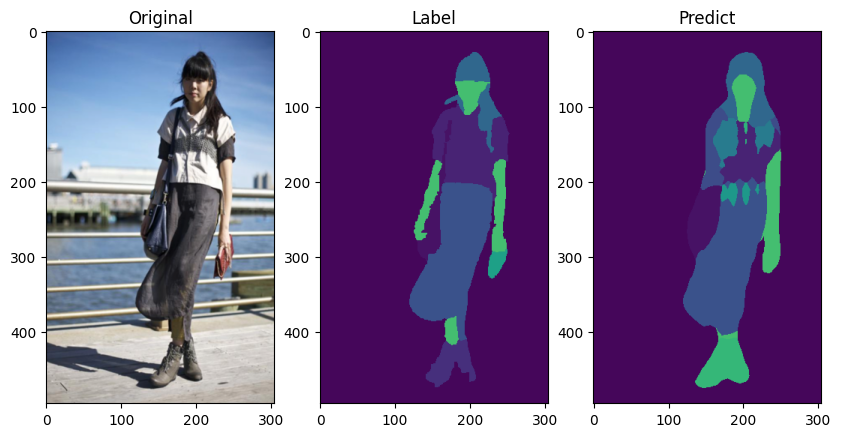

Real classes: ['none', 'hat', 'hair', 'skin', 'shirt', 'blazer', 'shorts', 'purse', 'shoes']
Predicted classes: ['none', 'hat', 'hair', 'skin', 'coat', 'shirt', 'jacket', 'blouse', 'suit', 'sweater', 'dress', 'skirt', 'shorts', 'bag', 'shoes']


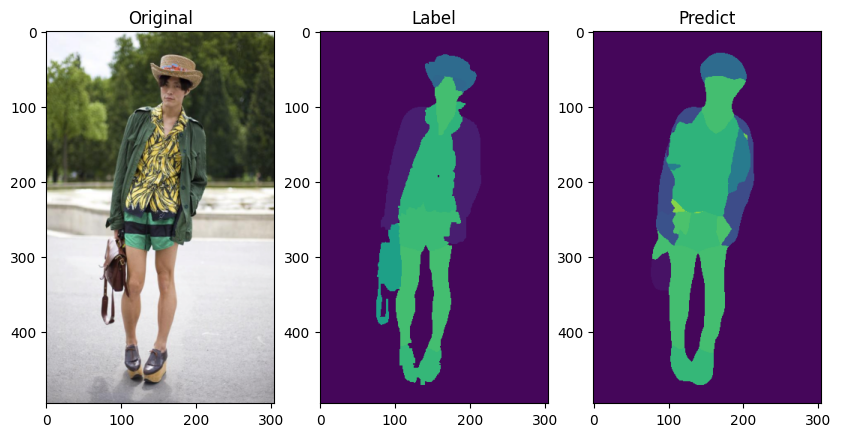

Real classes: ['none', 'hair', 'skin', 'dress', 'stockings', 'pumps']
Predicted classes: ['none', 'hair', 'skin', 'scarf', 'dress', 'coat', 'blazer', 'pants', 'blouse', 'skirt', 'shoes']


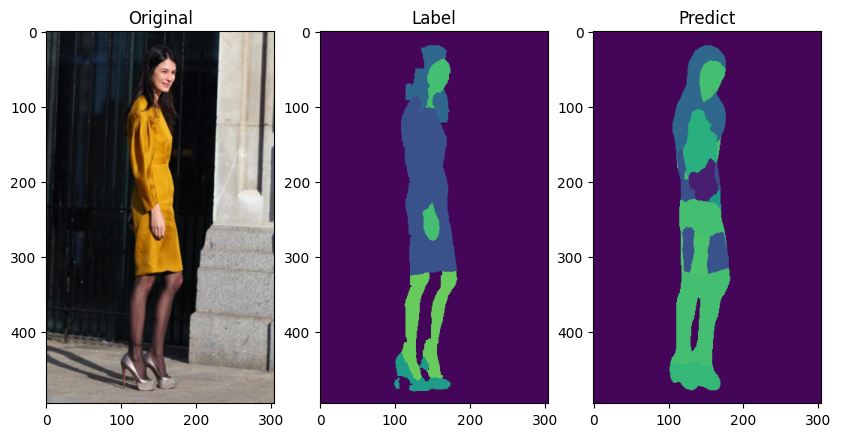

In [170]:
undo_transforms = transforms.Compose([
    transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    ),
    transforms.Lambda(lambda x: x * 255)    
])

for x, y in test_loader:
    for input, label in zip(x.unbind(0), y.unbind(0)):       
        predict, classes_predicted = decoder.decode_labels(model_output(model, input.to(device), label.to(device)).cpu())
        img_label, classes_real = decoder.decode_labels(label)
    
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original")

        input = undo_transforms(input)

        plt.imshow(np.transpose(input.int(), (1, 2, 0)))
        plt.subplot(1, 3, 2)

        plt.imshow(img_label)
        plt.title("Label")
        plt.subplot(1, 3, 3)

        plt.imshow(predict)
        plt.title("Predict")
        print("Real classes:", classes_real)
        print("Predicted classes:", classes_predicted)
        plt.show()
        break

#### Test final

Predicted classes: ['none', 'hair', 'skin', 'coat', 'suit', 'blazer', 'pants', 'jeans', 'shoes']


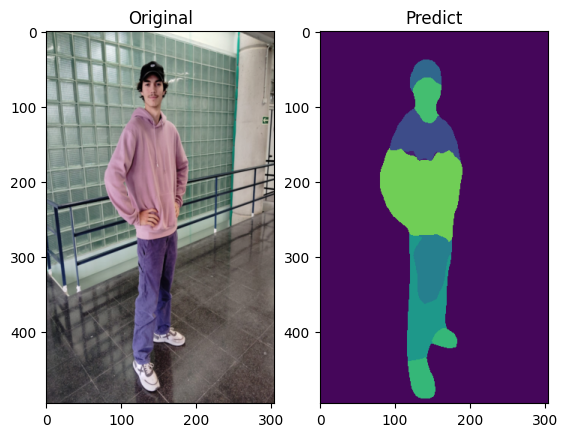

In [172]:

input = read_image("./data/dani2.jpg")
transformation = transforms.Compose([
    transforms.Resize((496, 304), interpolation=InterpolationMode.BILINEAR, antialias=True), 
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input = transformation(input)

predict, classes_predicted = decoder.decode_labels(model_output(model, input.to(device), label.to(device)).cpu())

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
input = undo_transforms(input)
plt.imshow(np.transpose(input.int(), (1, 2, 0)))
plt.subplot(1, 3, 2)
plt.imshow(predict)
plt.title("Predict")

print("Predicted classes:", classes_predicted)
plt.show()
